In [71]:
#Requirements:  1000 MKIDS on single readout line 
#               The bandwidth is 4-8 GHz
#               Smallest detectable wavelength is 402 nm
#               Q factor is constant on all frequencies
#               
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *
#%matplotlib widget
import kidcalc as kc # KID model
import SC # properties of superconducting materials

In [72]:
#Design parameters
N_MKIDs = 1000
N_read = int(1e3)
f0 = 4.004e9 #Hz resonance frequency
kbT0 = 86.17 * .1 #µeV, operating temperature of 100 mK
hw0 = 6.582e-4*2*np.pi*f0*1e-6 #Energy inherent in KID at fres
Qi_sat = 1e16
Qc = 5.0e4     #Coupling quality factor
W_ind = 4 #Inductor width in µm
L_ind = 626 #Inductor length in µm
d_ind = 40e-3 #Inductor film thickness is µm
# V_ind = W_ind *L_ind * d_ind
V_ind = 15 # µm^3 inductor volume

supercond = SC.bTa() # material constants
ak = .96 # Kinetic Inductance fraction
beta = 2    #Thin film beta approximation
lmbda = 402 #nm, gives the max. E for the responsivity curve
etapb = .55 #Pair breaking efficiency 

print(V_ind)

15


In [103]:
dNqp = etapb * 6.528e-4*2*np.pi* 3e8 / (lmbda * 1e-3) / supercond.D0
Nqp0 = V_ind * kc.nqp(kbT0, supercond.D0, supercond)
kbTeff = kc.kbTeff((Nqp0 + dNqp)/V_ind, supercond)

# calculate equilibrium complex conductivity, Qi, Lk and from that C and Lg (for later fres calc)
s10, s20 = kc.cinduct(hw0, supercond.D0, kbT0)
Qi_Nqp0 = 2/(ak*beta) * s20/s10
Qi0 = Qi_Nqp0 * Qi_sat / (Qi_Nqp0 + Qi_sat)  #Physical systems have limited Qi
Q = Qc * Qi0 / (Qc + Qi0)
Lk0 = np.imag(1/(s10-1j*s20))/(2*np.pi*f0)
C = ak/(f0**2*Lk0)  #Capacitance from resonance freq definition, factor (2pi)^2 missing?
Lg = Lk0*(1/ak-1)

#Define frequency range of interest 
f_read_min = f0 - 8*f0/Q
f_read_max = f0 + 4*f0/Q
f_read = np.linspace(f_read_min, f_read_max, N_read)
f_dis = 0.3e6

print(Qi_Nqp0/1e4, Qc)

6966.325832476297 50000.0


In [74]:
#calculate complex conductivities and excess quasiparticles during pulse (between kbT0 and kbTeff)
kbTarr = np.logspace(np.log10(kbT0), np.log10(kbTeff), N_read)
s1, s2, exNqp = np.zeros((3, len(kbTarr)))
for i, kbT in enumerate(kbTarr):
    s1[i], s2[i] = kc.cinduct(hw0, supercond.D0, kbT)
    exNqp[i] = V_ind * kc.nqp(kbT, supercond.D0, supercond)

In [104]:
S21_0 = kc.S21(Qi0, Qc, f_read, f0) 
S21_1 = kc.S21(Qi0, Qc, f_read, f0-f_dis)

Lk = np.imag(1/(s1-1j*s2))/(2*np.pi*f0)
f_resp = 1/np.sqrt(C*(Lk + Lg))
Qi_resp = (2*s2)/(ak*beta*s1)
Q_resp = Qc * Qi_resp / (Qc + Qi_resp)

S21_resp = kc.S21(min(Qi_resp), Qc, f_read, min(f_resp))
S21_prod = S21_0*S21_1

In [105]:
def interact_S21():
    ## Set up the plot data
    fig   = plt.figure(figsize=(8,3))
    plt.plot(f_read,10*np.log10(np.abs(S21_0*S21_1)), linewidth=1, label="Unloaded S21")
    line, = plt.plot([], [], linewidth=2, label="Loaded S21", color = "indianred")# Initialize curve to empty data.

    ## Set up the figure axes, etc.
    plt.title("Varying Qi")
    plt.xlim(min(f_read), max(f_read))
    plt.ylim(-40, 0.1)
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('S21 (dB)')
    plt.legend()
    plt.close()      # Don't show the figure yet.

    ## Callback function
    def plot_S21(kbT_slider,f_dis_slider):
        s1_resp, s2_resp = kc.cinduct(hw0, supercond.D0, kbT_slider)
        Lk_resp = np.imag(1/(s1_resp-1j*s2_resp))/(2*np.pi*f0)
        f_resp = 1/np.sqrt(C*(Lk_resp + Lg))
        Qi_resp = (2*s2_resp)/(ak*beta*s1_resp)
        S21_resp = kc.S21(Qi_resp, Qc, f_read, f_resp)
        S21_1_var = kc.S21(Qi0, Qc, f_read, f0-f_dis_slider)
        line.set_data(f_read, 10*np.log10(np.abs(S21_resp*S21_1_var)))
        display(fig)
        

    ## Generate the user interface.
    interact(plot_S21, 
             kbT_slider=FloatSlider(min=min(kbTarr), max=1.1*max(kbTarr), step=0.1, value=kbT0, description = r"T_eff"),
             f_dis_slider = FloatSlider(min =1e3 , max = f_dis, step = 1e4, value = f_dis, description = "f_shift"))

interact_S21();


interactive(children=(FloatSlider(value=8.617, description='T_eff', max=17.970187669379268, min=8.617), FloatS…

In [106]:
for count, val in enumerate(S21_resp):
    if np.abs(val) == min(np.abs(S21_resp)):
        print(f_read[count])
        print("Highest shift:",(f0 - f_read[count])/1e6, "MHz")


S21_0min = min(Q_resp)/min(Qi_resp)
print(10*np.log10(np.abs(S21_0min)))

4003772823.4900517
Highest shift: 0.22717650994825364 MHz
-1.2930766830016442


In [115]:
def interact_circle():
    ## Set up the plot data
    fig   = plt.figure(figsize=(5,5))
    # plt.plot(f_read,10*np.log10(np.abs(S21_0*S21_1)), linewidth=1, label="Unloaded S21")
    line, = plt.plot([], [], linewidth=2, label="Loaded S21", color = "indianred")# Initialize curve to empty data.

    ## Set up the figure axes, etc.
    plt.title("Resonance circle")
    plt.xlim(0, 2)
    plt.ylim(-1, 1)
    plt.xlabel('Re(S21)')
    plt.ylabel('Im(S21)')
    plt.legend()
    plt.close()      # Don't show the figure yet.

    ## Callback function
    def plot_circle(kbT_slider,f_dis_slider):
        s1_resp, s2_resp = kc.cinduct(hw0, supercond.D0, kbT_slider)
        Lk_resp = np.imag(1/(s1_resp-1j*s2_resp))/(2*np.pi*f0)
        f_resp = 1/np.sqrt(C*(Lk_resp + Lg))
        Qi_resp = (2*s2_resp)/(ak*beta*s1_resp)
        S21_resp = kc.S21(Qi_resp, Qc, f_read, f_resp)
        S21_1_var = kc.S21(Qi0, Qc, f_read, f0-f_dis_slider)
        S21_combined = S21_resp + S21_1_var
        line.set_data(np.real(S21_combined), np.imag(S21_combined))
        display(fig)
        

    ## Generate the user interface.
    interact(plot_circle, 
             kbT_slider=FloatSlider(min=min(kbTarr), max=1.1*max(kbTarr), step=0.1, value=kbT0, description = r"T_eff"),
             f_dis_slider = FloatSlider(min =1e3 , max = f_dis, step = 1e4, value = f_dis, description = "f_shift"))

interact_circle();

interactive(children=(FloatSlider(value=8.617, description='T_eff', max=17.970187669379268, min=8.617), FloatS…

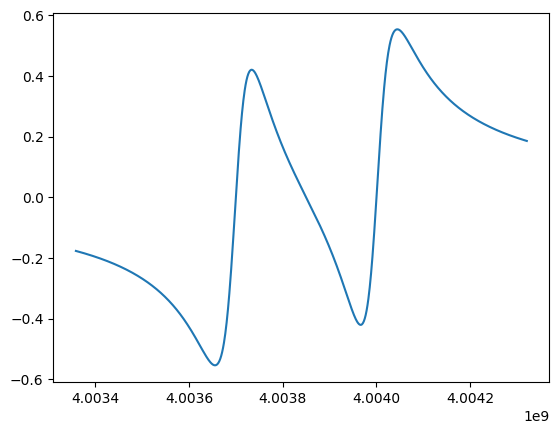

In [116]:
plt.close()
plt.plot(f_read,np.imag(S21_prod))
plt.show()